# BigQuery Vector Search

End to end process for performing Vector Search on BigQuery

This utilizes


*   Multi-modal embeddings in BQ via vertex remote models
*   Create Vector Index using BQ create vector_index()
*   Vector Search in BQ
*   All in a BQ Studio Colab notebook
*   Bigframes for image data processing



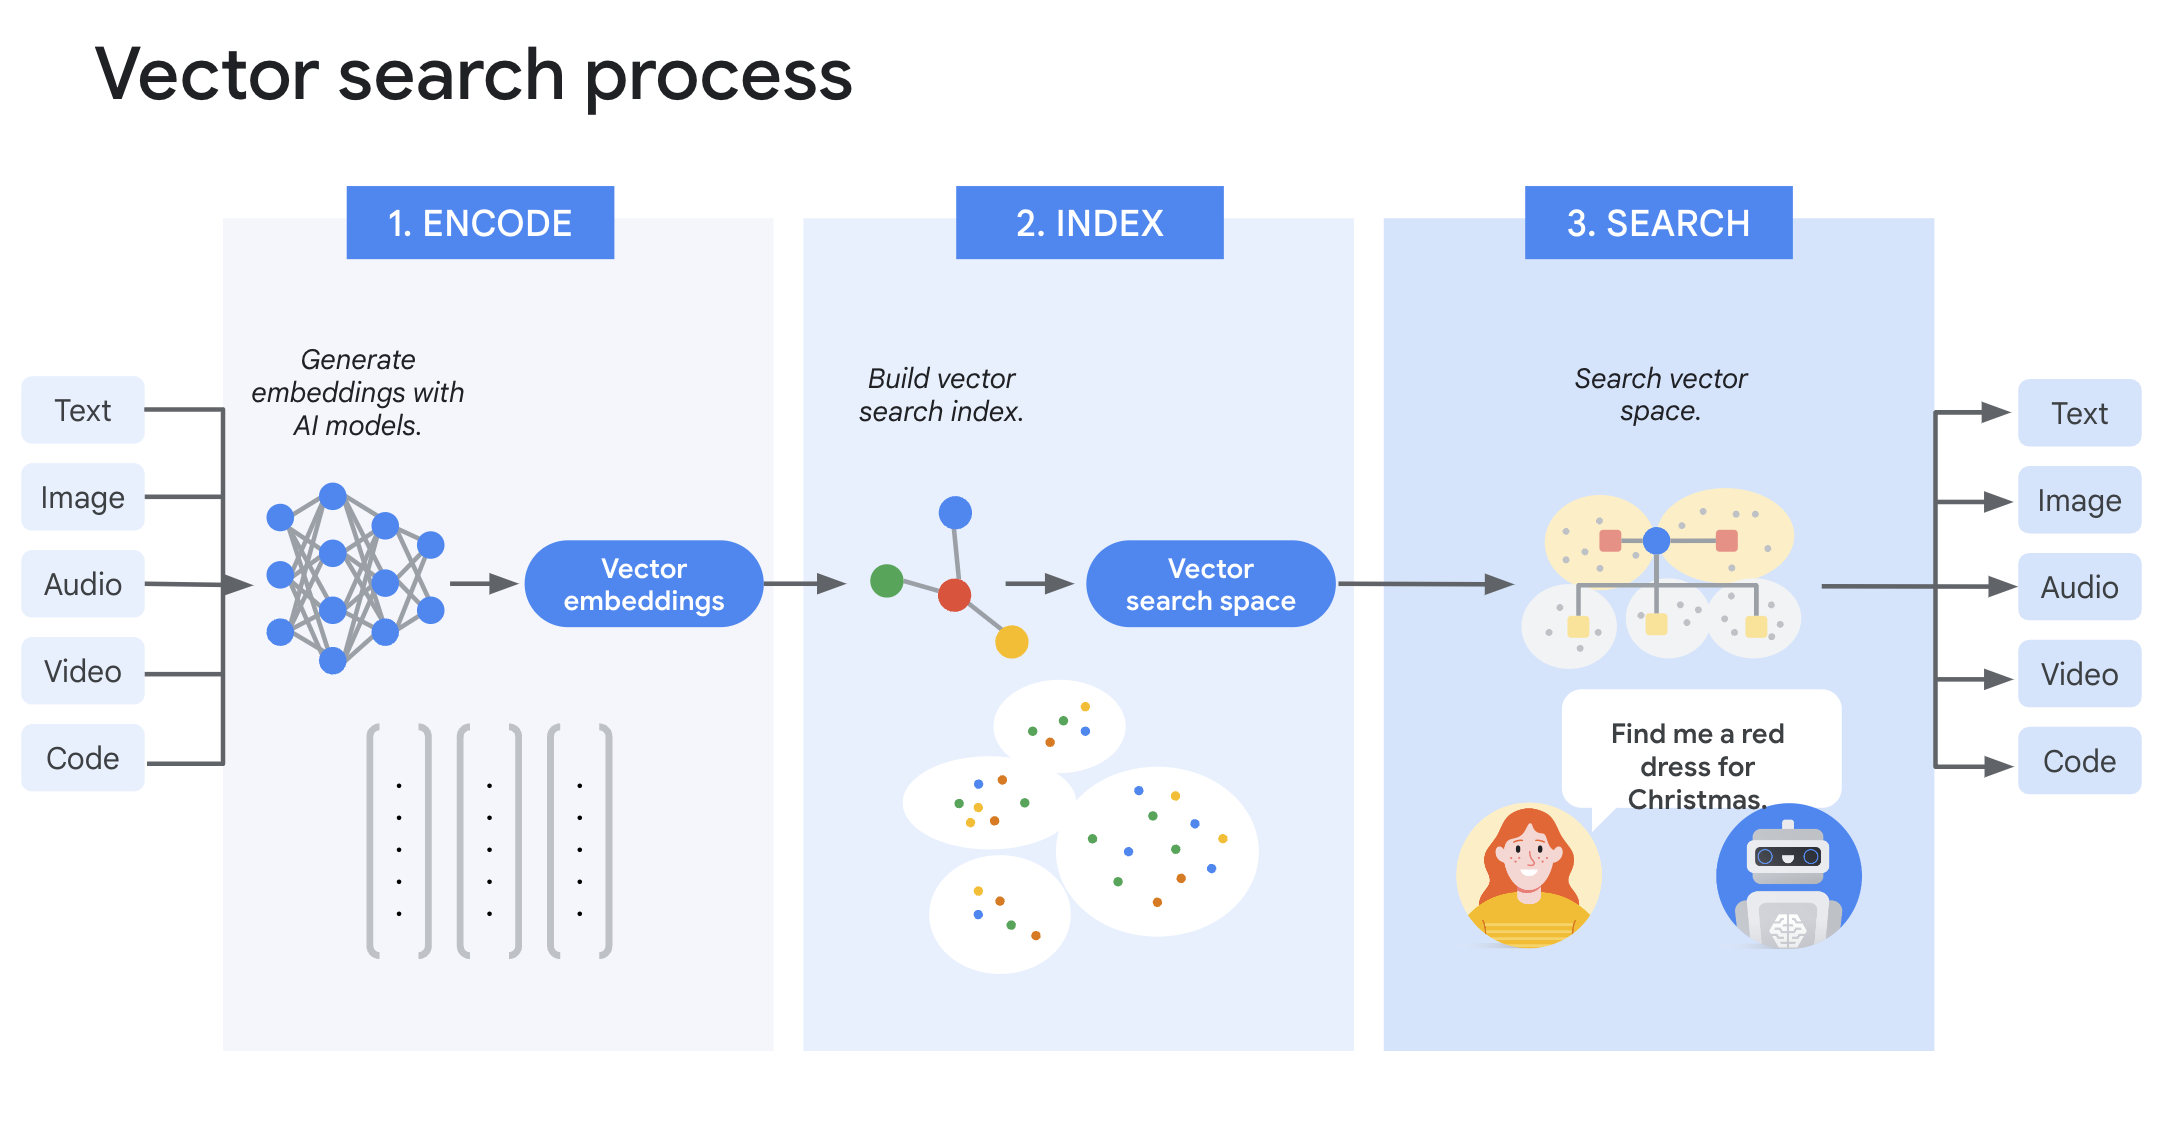


## Setup & initialization

Make sure you have the required roles and permissions listed below:

For Vector embedding generation: https://cloud.google.com/bigquery/docs/generate-text-embedding#required_roles

For Vector Index creation: https://cloud.google.com/bigquery/docs/vector-index#roles_and_permissions

### Setup variables

***Change as per your project settings***

In [ ]:
PROJECT_ID = "johanesa-playground-326616"  # @param {type:"string"}
DATASET_ID = "demo_dataset"  # @param {type:"string"}
CONNECTION_ID = "gcs-connection"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [ ]:
REGION = "US"  # @param {type: "string"}

In [ ]:
## Text embedding variables

TEXT_TABLE_ID = "PATENT_TABLE"
TEXT_MODEL_ID = "llm_embedding_model"
TEXT_EMBEDDING_TABLE_ID = "patent_embedding"
TEXT_MODEL_ENDPOINT = "textembedding-gecko@latest"
TEXT_VECTOR_INDEX_ID = "patent_index"



## Multi-modal (MM) embedding variables

MM_OBJ_TABLE_ID = "global_food_images"
MM_MODEL_ID = "multimodal_embedding_model"
MM_EMBEDDING_TABLE_ID = "global_food_images_embedding"
MM_MODEL_ENDPOINT = "multimodalembedding@001"
MM_VECTOR_INDEX_ID = "global_food_index_13k"



Install libraries

In [ ]:
import bigframes.pandas as bf


from google.cloud import bigquery
from google.cloud import storage

# Construct a BigQuery client object.
client = bigquery.Client()

import pandas as pd
from IPython.display import Image, display
from PIL import Image as PILImage
import io

In [ ]:
bf.options.bigquery.project = PROJECT_ID
bf.options.bigquery.location = REGION

## Text embedding

### 1. Encode

In [ ]:
## create text embedding remote model

query = ('''
CREATE OR REPLACE MODEL
  `{DATASET_ID}.{TEXT_MODEL_ID}`
  REMOTE WITH CONNECTION `{REGION}.{CONNECTION_ID}` OPTIONS (ENDPOINT = '{TEXT_MODEL_ENDPOINT}')
;
''').format(DATASET_ID= DATASET_ID, CONNECTION_ID=CONNECTION_ID, REGION=REGION,
            TEXT_MODEL_ID  = TEXT_MODEL_ID , TEXT_MODEL_ENDPOINT=TEXT_MODEL_ENDPOINT)

print(query)
client.query(query).result()


CREATE OR REPLACE MODEL
  `demo_dataset.llm_embedding_model`
  REMOTE WITH CONNECTION `US.gcs-connection` OPTIONS (ENDPOINT = 'textembedding-gecko@latest')
;



In [ ]:
## create patents base table (subset of 5M out of ~110M records)
## Use BQ public dataset of Patents

query = ('''
CREATE OR REPLACE TABLE `{DATASET_ID}.{TEXT_TABLE_ID}`
AS
SELECT *
FROM `patents-public-data.google_patents_research.publications`
WHERE ARRAY_LENGTH(embedding_v1) > 0
and length(title) >0 and length(abstract) >0
LIMIT 5000000
;
''').format(DATASET_ID= DATASET_ID, TEXT_TABLE_ID = TEXT_TABLE_ID)

print(query)
client.query(query).result()


CREATE OR REPLACE TABLE `demo_dataset.PATENT_TABLE`
AS
SELECT *
FROM `patents-public-data.google_patents_research.publications`
WHERE ARRAY_LENGTH(embedding_v1) > 0
and length(title) >0 and length(abstract) >0
LIMIT 5000000
;



In [ ]:
## create embedding for the "abstract" column in the patents table
## takes ~ 40mins (100k records) - adjust according to your need
## takes ~ 4h30mins (1M records)
## if using a different dataset, please update the column names in the query

query = ('''
create or replace table `{DATASET_ID}.{TEXT_EMBEDDING_TABLE_ID}`
as
SELECT publication_number, title, content, ml_generate_embedding_result
FROM ML.GENERATE_EMBEDDING(
  MODEL `{DATASET_ID}.{TEXT_MODEL_ID}`,
  (
    SELECT publication_number,title, abstract as content
    from `{DATASET_ID}.{TEXT_TABLE_ID}`
    where length(abstract) > 30
    LIMIT 1000000
  )
)
WHERE ml_generate_embedding_status IS NULL OR LENGTH(ml_generate_embedding_status) = 0
;
''').format(DATASET_ID= DATASET_ID, TEXT_MODEL_ID = TEXT_MODEL_ID, TEXT_TABLE_ID = TEXT_TABLE_ID,
            TEXT_EMBEDDING_TABLE_ID = TEXT_EMBEDDING_TABLE_ID)

print(query)
client.query(query).result()


create or replace table `demo_dataset.patent_embedding`
as
SELECT publication_number, title, content, ml_generate_embedding_result
FROM ML.GENERATE_EMBEDDING(
  MODEL `demo_dataset.llm_embedding_model`,
  (
    SELECT publication_number,title, abstract as content
    from `demo_dataset.PATENT_TABLE`
    where length(abstract) > 30
    LIMIT 1000000
  )
)
WHERE ml_generate_embedding_status IS NULL OR LENGTH(ml_generate_embedding_status) = 0
;



In [ ]:
## See a snapshot of the table generated

query = ('''
SELECT * from `{DATASET_ID}.{TEXT_EMBEDDING_TABLE_ID}` limit 5
;
''').format(DATASET_ID= DATASET_ID, TEXT_MODEL_ID = TEXT_MODEL_ID,
            TEXT_EMBEDDING_TABLE_ID = TEXT_EMBEDDING_TABLE_ID)

print(query)
client.query(query).to_dataframe()


SELECT * from `demo_dataset.patent_embedding` limit 5
;



,publication_number,title,content,ml_generate_embedding_result
0,KR-100785017-B1,How to Amplify Nucleic Acids from Blood,The present invention comprises the steps of e...,"[-0.009067947044968605, 0.00900828093290329, -..."
1,CN-109715159-A,Anticancer drug composition,The present invention provides a pharmaceutica...,"[0.007525038439780474, 0.017499608919024467, -..."
2,CN-117202625-A,A video storage server security protection device,The invention discloses a security protection ...,"[-0.013766400516033173, 0.029313789680600166, ..."
3,CN-108015479-A,Welding platform hydraulic support,The present invention announces a kind of weld...,"[-0.009089660830795765, 0.02148457057774067, -..."
4,CN-212482487-U,Target plate fixing device,"A target plate holding apparatus, the target p...","[-0.003614683635532856, -0.026118779554963112,..."


### 2. Index

[Create a Vector Index](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-definition-language#create_vector_index_statement)


**Index Type**

Required. The algorithm to use to build the vector index. IVF is the only supported value. Specifying IVF builds the vector index as an inverted file index (IVF). An IVF uses a k-means algorithm to cluster the vector data, and then partitions the vector data based on those clusters. When you use the VECTOR_SEARCH function to search the vector data, it can use these partitions to reduce the amount of data it needs to read in order to determine a result.

**Distance Type**

Specifies the default distance type to use when performing a vector search using this index. The supported values are EUCLIDEAN and COSINE. EUCLIDEAN is the default.
The index creation itself always uses EUCLIDEAN distance for training but the distance used in the VECTOR_SEARCH function can be different.

If you specify a value for the distance_type argument of the VECTOR_SEARCH function, that value is used instead of the vector index's distance_type value.

**IVF Options**

The options to use with the IVF algorithm. Defaults to '{}' to denote that all underlying options use their corresponding default values.
The only supported option is num_lists. Specify an INT64 less than or equal to 5,000 that determines how many lists the IVF algorithm creates. For example, ivf_options = '{\"num_lists\":1000}'.

The IVF algorithm divides the whole data space into a number of lists equal to the num_lists value, with data points that are closer to each other being more likely to be put on the same list. If the num_lists value is small, you have fewer lists with more data points, while a larger value creates more lists with fewer data points.

You can use num_lists in combination with the fractions_list_to_search argument of the VECTOR_SEARCH function to create an efficient vector search. When you have data that is distributed in many small groups in the embedding space, specify a high num_lists value to create an index with more lists and specify a lower fractions_list_to_search value to scan fewer of those lists in vector search. Use a lower num_lists value and a higher fractions_list_to_search value when your data is distributed in fewer, larger groups. Using a high num_lists value might make the vector index take longer to build.

If you don't specify a value for num_lists, BigQuery calculates an appropriate value.

In [ ]:
## create vector index for the embeddings
## takes ~2-20min to run (depending on size of table, takes bit longer for the actual indexing to complete)- see next cell
## change num lists in options through the variable as needed, see note above

NUM_LISTS = 5000

query = ('''
CREATE OR REPLACE VECTOR INDEX `{TEXT_VECTOR_INDEX_ID}`
ON `{DATASET_ID}.{TEXT_EMBEDDING_TABLE_ID}` (ml_generate_embedding_result)
OPTIONS(
  distance_type="COSINE",
  index_type="IVF",
  ivf_options='{{"num_lists":{NUM_LISTS}}}');
''').format(DATASET_ID= DATASET_ID, TEXT_EMBEDDING_TABLE_ID=TEXT_EMBEDDING_TABLE_ID, TEXT_VECTOR_INDEX_ID=TEXT_VECTOR_INDEX_ID, NUM_LISTS = NUM_LISTS)

print(query)
client.query(query).result()


CREATE OR REPLACE VECTOR INDEX `patent_index`
ON `demo_dataset.patent_embedding` (ml_generate_embedding_result)
OPTIONS(
  distance_type="COSINE",
  index_type="IVF",
  ivf_options='{"num_lists":5000}');



**Get information about vector indexes**

You can verify the existence and the readiness of a vector index by querying INFORMATION_SCHEMA. Note that the DDL could take some time to finish, but it does not mean the index is fully populated when it is done. Please always use the INFORMATION_SCHEMA to verify the readiness of a vector index. Note that when the index is not ready, VECTOR_SEARCH still works by falling back to using brute force.

In [ ]:
## check index status
## always check this before running a vector search on the indexed table.

query = ('''
SELECT table_name, index_name, ddl, coverage_percentage, unindexed_row_count
FROM `{DATASET_ID}.INFORMATION_SCHEMA.VECTOR_INDEXES`
WHERE index_status = 'ACTIVE';
''').format(DATASET_ID= DATASET_ID)

print(query)
client.query(query).to_dataframe()


SELECT table_name, index_name, ddl, coverage_percentage, unindexed_row_count
FROM `demo_dataset.INFORMATION_SCHEMA.VECTOR_INDEXES`
WHERE index_status = 'ACTIVE';



,table_name,index_name,ddl,coverage_percentage,unindexed_row_count
0,patent_embedding,patent_index,CREATE VECTOR INDEX `patent_index` ON `johanes...,100,0


### 3. Search


***Vector Search***


**top_k:** An optional INT64 mandatory-named argument. top_k_value specifies the number of nearest neighbors to return. The default is 10. A negative value is treated as infinity, meaning that all values are counted as neighbors and returned.

**distance_type:** An optional STRING mandatory-named argument. distance_type_value specifies the type of metric to use to compute the distance between two vectors. Supported distance types are EUCLIDEAN and COSINE. The default is EUCLIDEAN.

If you don't specify distance_type_value and the column_to_search column has a vector index that is used, VECTOR_SEARCH uses the distance type specified in the distance_type option of the CREATE VECTOR INDEX statement.

*options: An optional JSON-formatted STRING mandatory-named argument. options_value is a literal that specifies the following vector search options:*

**fraction_lists_to_search:** A JSON number that specifies the percentage of lists to search. For example, options => '{"fraction_lists_to_search":0.15}'. The fraction_lists_to_search value must be in the range 0.0 to 1.0, exclusive.

Specifying a higher percentage leads to higher recall and slower performance, and the converse is true when specifying a lower percentage.

fraction_lists_to_search is only used when a vector index is also used. If you don't specify a fraction_lists_to_search value but an index is matched, the default number of lists to scan is calculated as min(0.002 * number_of_lists, 10).

The number of available lists to search is determined by the num_lists option in the ivf_options option of the CREATE VECTOR INDEX statement if that is specified. Otherwise, BigQuery calculates an appropriate number.

You can't specify fraction_lists_to_search when use_brute_force is set to true.

**use_brute_force:** A JSON boolean that determines whether to use brute force search by skipping the vector index if one is available. For example, options => '{"use_brute_force":true}'. The default is false. If you specify use_brute_force=false and there is no useable vector index available, brute force is used anyway.

#### Set variables for Text vector search

In [ ]:
TEXT_SEARCH_STRING = "Chip assemblies employing solder bonds to back-side lands including an electrolytic nickel layer"  ## replace with whatever search string you want to use for the vector search
FRACTION_LISTS_TO_SEARCH = 0.01

#### ANN (approx nearest neighbor) search using the created vector index





In [ ]:
query = """
SELECT
query.query,base.publication_number,base.title,base.content, distance
FROM VECTOR_SEARCH
(
TABLE `{DATASET_ID}.{TEXT_EMBEDDING_TABLE_ID}`, 'ml_generate_embedding_result',
(SELECT ml_generate_embedding_result, content AS query,
FROM ML.GENERATE_EMBEDDING(
MODEL `{DATASET_ID}.{TEXT_MODEL_ID}`,
(SELECT "{TEXT_SEARCH_STRING}" AS content),
STRUCT(TRUE AS flatten_json_output)
)),
top_k => 5,
distance_type => 'EUCLIDEAN',
options => '{{"fraction_lists_to_search": {FRACTION_LISTS_TO_SEARCH}}}');
    """.format(
        DATASET_ID = DATASET_ID, TEXT_MODEL_ID = TEXT_MODEL_ID,
        TEXT_EMBEDDING_TABLE_ID = TEXT_EMBEDDING_TABLE_ID,
        TEXT_SEARCH_STRING=TEXT_SEARCH_STRING, FRACTION_LISTS_TO_SEARCH = FRACTION_LISTS_TO_SEARCH
    )

print(query)
client.query(query).to_dataframe()


SELECT
query.query,base.publication_number,base.title,base.content, distance
FROM VECTOR_SEARCH
(
TABLE `demo_dataset.patent_embedding`, 'ml_generate_embedding_result',
(SELECT ml_generate_embedding_result, content AS query,
FROM ML.GENERATE_EMBEDDING(
MODEL `demo_dataset.llm_embedding_model`,
(SELECT "Chip assemblies employing solder bonds to back-side lands including an electrolytic nickel layer" AS content),
STRUCT(TRUE AS flatten_json_output)
)),
top_k => 5,
distance_type => 'EUCLIDEAN',
options => '{"fraction_lists_to_search": 0.01}');
    


,query,publication_number,title,content,distance
0,Chip assemblies employing solder bonds to back...,US-4946376-A,Backside metallization scheme for semiconducto...,A backside metalization scheme for semiconduct...,0.592216
1,Chip assemblies employing solder bonds to back...,CN-1392761-A,Method for high reliable packaged electronic e...,An electronic component that is provided with ...,0.594339
2,Chip assemblies employing solder bonds to back...,EP-2441087-A2,"Method for manufacturing tight pitch, flip chi...",A flip chip packaging method to attach a die t...,0.597755
3,Chip assemblies employing solder bonds to back...,CN-1799112-A,Plated terminations,A multilayer electronic component includes a p...,0.599331
4,Chip assemblies employing solder bonds to back...,CN-113330562-A,Method of precision redistribution interconnec...,A method is disclosed for fabricating electric...,0.606143


#### Exact search (Brute force Vector search)

In [ ]:
query = """

SELECT
query.query,base.publication_number,base.title,base.content, distance
FROM VECTOR_SEARCH
(
TABLE `{DATASET_ID}.{TEXT_EMBEDDING_TABLE_ID}`, 'ml_generate_embedding_result',
(SELECT ml_generate_embedding_result, content AS query,
FROM ML.GENERATE_EMBEDDING(
MODEL `{DATASET_ID}.{TEXT_MODEL_ID}`,
(SELECT "{TEXT_SEARCH_STRING}" AS content),
STRUCT(TRUE AS flatten_json_output)
)),
top_k => 5,
distance_type => 'EUCLIDEAN',
options => '{{"use_brute_force":true}}');
    """.format(
        DATASET_ID = DATASET_ID, TEXT_MODEL_ID = TEXT_MODEL_ID,
        TEXT_EMBEDDING_TABLE_ID = TEXT_EMBEDDING_TABLE_ID,
        TEXT_SEARCH_STRING=TEXT_SEARCH_STRING, FRACTION_LISTS_TO_SEARCH = FRACTION_LISTS_TO_SEARCH
    )

print(query)
client.query(query).to_dataframe()



SELECT
query.query,base.publication_number,base.title,base.content, distance
FROM VECTOR_SEARCH
(
TABLE `demo_dataset.patent_embedding`, 'ml_generate_embedding_result',
(SELECT ml_generate_embedding_result, content AS query,
FROM ML.GENERATE_EMBEDDING(
MODEL `demo_dataset.llm_embedding_model`,
(SELECT "Chip assemblies employing solder bonds to back-side lands including an electrolytic nickel layer" AS content),
STRUCT(TRUE AS flatten_json_output)
)),
top_k => 5,
distance_type => 'EUCLIDEAN',
options => '{"use_brute_force":true}');
    


,query,publication_number,title,content,distance
0,Chip assemblies employing solder bonds to back...,US-4946376-A,Backside metallization scheme for semiconducto...,A backside metalization scheme for semiconduct...,0.592216
1,Chip assemblies employing solder bonds to back...,CN-1392761-A,Method for high reliable packaged electronic e...,An electronic component that is provided with ...,0.594339
2,Chip assemblies employing solder bonds to back...,EP-2441087-A2,"Method for manufacturing tight pitch, flip chi...",A flip chip packaging method to attach a die t...,0.597755
3,Chip assemblies employing solder bonds to back...,CN-1799112-A,Plated terminations,A multilayer electronic component includes a p...,0.599331
4,Chip assemblies employing solder bonds to back...,CN-113330562-A,Method of precision redistribution interconnec...,A method is disclosed for fabricating electric...,0.606143


### Compare recall of using ANN (vector index) vs Exact search (brute force)

In [ ]:
query = """
with vector_index_results as
(
SELECT
query.query AS query_publication_number,
    base.publication_number AS base_publication_number
FROM VECTOR_SEARCH
(
TABLE `{DATASET_ID}.{TEXT_EMBEDDING_TABLE_ID}`, 'ml_generate_embedding_result',
(SELECT ml_generate_embedding_result, content AS query,
FROM ML.GENERATE_EMBEDDING(
MODEL `{DATASET_ID}.{TEXT_MODEL_ID}`,
(SELECT "{TEXT_SEARCH_STRING}" AS content),
STRUCT(TRUE AS flatten_json_output)
)),
top_k => 5,
distance_type => 'COSINE',
options => '{{"fraction_lists_to_search": {FRACTION_LISTS_TO_SEARCH}}}')
),
brute_force_results as
(
SELECT
query.query AS query_publication_number,
    base.publication_number AS base_publication_number
FROM VECTOR_SEARCH
(
TABLE `{DATASET_ID}.{TEXT_EMBEDDING_TABLE_ID}`, 'ml_generate_embedding_result',
(SELECT ml_generate_embedding_result, content AS query,
FROM ML.GENERATE_EMBEDDING(
MODEL `{DATASET_ID}.{TEXT_MODEL_ID}`,
(SELECT "{TEXT_SEARCH_STRING}" AS content),
STRUCT(TRUE AS flatten_json_output)
)),
top_k => 5,
distance_type => 'COSINE',
options => '{{"use_brute_force":true}}')
)
SELECT
  a.query_publication_number,
  SUM(CASE WHEN a.base_publication_number = e.base_publication_number THEN 1 ELSE 0 END) / 5 AS recall
FROM brute_force_results e LEFT JOIN vector_index_results a
  ON e.query_publication_number = a.query_publication_number
GROUP BY a.query_publication_number
""".format(
        DATASET_ID = DATASET_ID, TEXT_MODEL_ID = TEXT_MODEL_ID,
        TEXT_EMBEDDING_TABLE_ID = TEXT_EMBEDDING_TABLE_ID,
        TEXT_SEARCH_STRING=TEXT_SEARCH_STRING, FRACTION_LISTS_TO_SEARCH = FRACTION_LISTS_TO_SEARCH
    )

print(query)
client.query(query).to_dataframe()


with vector_index_results as
(
SELECT
query.query AS query_publication_number,
    base.publication_number AS base_publication_number
FROM VECTOR_SEARCH
(
TABLE `demo_dataset.patent_embedding`, 'ml_generate_embedding_result',
(SELECT ml_generate_embedding_result, content AS query,
FROM ML.GENERATE_EMBEDDING(
MODEL `demo_dataset.llm_embedding_model`,
(SELECT "Chip assemblies employing solder bonds to back-side lands including an electrolytic nickel layer" AS content),
STRUCT(TRUE AS flatten_json_output)
)),
top_k => 5,
distance_type => 'COSINE',
options => '{"fraction_lists_to_search": 0.01}')
),
brute_force_results as
(
SELECT
query.query AS query_publication_number,
    base.publication_number AS base_publication_number
FROM VECTOR_SEARCH
(
TABLE `demo_dataset.patent_embedding`, 'ml_generate_embedding_result',
(SELECT ml_generate_embedding_result, content AS query,
FROM ML.GENERATE_EMBEDDING(
MODEL `demo_dataset.llm_embedding_model`,
(SELECT "Chip assemblies employing solder bonds to

,query_publication_number,recall
0,Chip assemblies employing solder bonds to back...,1.0


## Multimodal embedding

Used kaggle dataset of food images (any other image dataset of >5000 images can be used instead)
Just need to change the uri option when creating the object table in the Encode step below.

Note: multi-modal embedding creates vectors of dim 1408, gecko-text-embeddings creates vectors of length 768.

**Note**

you may not have default access to multi-modal embedding model creation in your Argolis project.
Request access by emailing: bq-vector-search@google.com

### 1. Encode

Create model
Create object table
Generate multimodal embeddings for the images in the GCS bucket

In [ ]:
## create multimodal embedding remote model

query = ('''
CREATE OR REPLACE MODEL
  `{DATASET_ID}.{MM_MODEL_ID}`
  REMOTE WITH CONNECTION `{REGION}.{CONNECTION_ID}` OPTIONS (ENDPOINT = '{MM_MODEL_ENDPOINT}')
;
''').format(DATASET_ID= DATASET_ID, CONNECTION_ID=CONNECTION_ID, REGION=REGION,
            MM_MODEL_ID = MM_MODEL_ID, MM_MODEL_ENDPOINT=MM_MODEL_ENDPOINT)

print(query)
client.query(query).result()


CREATE OR REPLACE MODEL
  `demo_dataset.multimodal_embedding_model`
  REMOTE WITH CONNECTION `US.gcs-connection` OPTIONS (ENDPOINT = 'multimodalembedding@001')
;



In [ ]:
## create an object table for images in GCS

query = ('''
CREATE OR REPLACE EXTERNAL TABLE `{DATASET_ID}.{MM_OBJ_TABLE_ID}`
WITH CONNECTION `{REGION}.{CONNECTION_ID}`
OPTIONS(
  object_metadata = 'SIMPLE',
  uris = ['gs://johanesa-temporary-us/Food_Images/*'] -- replace with your GCS bucket URI
);
''').format(DATASET_ID= DATASET_ID, MM_OBJ_TABLE_ID=MM_OBJ_TABLE_ID, REGION=REGION, CONNECTION_ID=CONNECTION_ID)

print(query)
client.query(query).result()


CREATE OR REPLACE EXTERNAL TABLE `demo_dataset.global_food_images`
WITH CONNECTION `US.gcs-connection`
OPTIONS(
  object_metadata = 'SIMPLE',
  uris = ['gs://johanesa-temporary-us/Food_Images/*'] -- replace with your GCS bucket URI
);



In [ ]:
## number of images in dataset

query = ('''
select count(*) from `{DATASET_ID}.{MM_OBJ_TABLE_ID}`;
''').format(DATASET_ID= DATASET_ID, MM_OBJ_TABLE_ID=MM_OBJ_TABLE_ID)

print(query)
client.query(query).to_dataframe()


select count(*) from `demo_dataset.global_food_images`;



,f0_
0,9866


In [ ]:
## create multimodal embeddings for the images (13582 images)
## takes ~1hr45min to run

query = ('''
CREATE OR REPLACE TABLE `{DATASET_ID}.{MM_EMBEDDING_TABLE_ID}`
AS
SELECT *
FROM ML.GENERATE_EMBEDDING(MODEL `{DATASET_ID}.{MM_MODEL_ID}`,
TABLE `{DATASET_ID}.{MM_OBJ_TABLE_ID}`);
''').format(DATASET_ID= DATASET_ID, MM_OBJ_TABLE_ID=MM_OBJ_TABLE_ID, MM_MODEL_ID=MM_MODEL_ID, MM_EMBEDDING_TABLE_ID=MM_EMBEDDING_TABLE_ID)

print(query)
client.query(query).result()


CREATE OR REPLACE TABLE `demo_dataset.global_food_images_embedding`
AS
SELECT *
FROM ML.GENERATE_EMBEDDING(MODEL `demo_dataset.multimodal_embedding_model`,
TABLE `demo_dataset.global_food_images`);



In [ ]:
## check length of embeddings

query = ('''
select avg(array_length(ml_generate_embedding_result)) from `{DATASET_ID}.{MM_EMBEDDING_TABLE_ID}`;
''').format(DATASET_ID= DATASET_ID, MM_EMBEDDING_TABLE_ID = MM_EMBEDDING_TABLE_ID)

print(query)
client.query(query).to_dataframe()


select avg(array_length(ml_generate_embedding_result)) from `demo_dataset.global_food_images_embedding`;



,f0_
0,1408.0


### 2. Index


[Create a Vector Index](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-definition-language#create_vector_index_statement)


**Index Type**

Required. The algorithm to use to build the vector index. IVF is the only supported value. Specifying IVF builds the vector index as an inverted file index (IVF). An IVF uses a k-means algorithm to cluster the vector data, and then partitions the vector data based on those clusters. When you use the VECTOR_SEARCH function to search the vector data, it can use these partitions to reduce the amount of data it needs to read in order to determine a result.

**Distance Type**

Specifies the default distance type to use when performing a vector search using this index. The supported values are EUCLIDEAN and COSINE. EUCLIDEAN is the default.
The index creation itself always uses EUCLIDEAN distance for training but the distance used in the VECTOR_SEARCH function can be different.

If you specify a value for the distance_type argument of the VECTOR_SEARCH function, that value is used instead of the vector index's distance_type value.

**IVF Options**

The options to use with the IVF algorithm. Defaults to '{}' to denote that all underlying options use their corresponding default values.
The only supported option is num_lists. Specify an INT64 less than or equal to 5,000 that determines how many lists the IVF algorithm creates. For example, ivf_options = '{\"num_lists\":1000}'.

The IVF algorithm divides the whole data space into a number of lists equal to the num_lists value, with data points that are closer to each other being more likely to be put on the same list. If the num_lists value is small, you have fewer lists with more data points, while a larger value creates more lists with fewer data points.

You can use num_lists in combination with the fractions_list_to_search argument of the VECTOR_SEARCH function to create an efficient vector search. When you have data that is distributed in many small groups in the embedding space, specify a high num_lists value to create an index with more lists and specify a lower fractions_list_to_search value to scan fewer of those lists in vector search. Use a lower num_lists value and a higher fractions_list_to_search value when your data is distributed in fewer, larger groups. Using a high num_lists value might make the vector index take longer to build.

If you don't specify a value for num_lists, BigQuery calculates an appropriate value.







**Note**

you may not have default access to index vectors over length 1000 in your Arglolis project.
Request access by emailing: bq-vector-search@google.com

In [ ]:
## create vector index for the images (13k images)
## takes ~2min to run (takes bit longer for the actual indexing to complete)- see next cell
## change num lists in options through the variable as needed, see note above

NUM_LISTS = 50

query = ('''
CREATE OR REPLACE VECTOR INDEX `{MM_VECTOR_INDEX_ID}`
ON `{DATASET_ID}.{MM_EMBEDDING_TABLE_ID}` (ml_generate_embedding_result)
OPTIONS(
  distance_type="COSINE",
  index_type="IVF",
  ivf_options='{{"num_lists":{NUM_LISTS}}}');
''').format(DATASET_ID= DATASET_ID, MM_EMBEDDING_TABLE_ID=MM_EMBEDDING_TABLE_ID, MM_VECTOR_INDEX_ID=MM_VECTOR_INDEX_ID, NUM_LISTS = NUM_LISTS)

print(query)
client.query(query).result()


CREATE OR REPLACE VECTOR INDEX `global_food_index_13k`
ON `demo_dataset.global_food_images_embedding` (ml_generate_embedding_result)
OPTIONS(
  distance_type="COSINE",
  index_type="IVF",
  ivf_options='{"num_lists":50}');



**Get information about vector indexes**

You can verify the existence and the readiness of a vector index by querying INFORMATION_SCHEMA. Note that the DDL could take some time to finish, but it does not mean the index is fully populated when it is done. Please always use the INFORMATION_SCHEMA to verify the readiness of a vector index. Note that when the index is not ready, VECTOR_SEARCH still works by falling back to using brute force.

In [ ]:
## check index status
## always check this before running a vector search on the indexed table.

query = ('''
SELECT table_name, index_name, ddl, coverage_percentage, unindexed_row_count
FROM `{DATASET_ID}.INFORMATION_SCHEMA.VECTOR_INDEXES`
WHERE index_status = 'ACTIVE';
''').format(DATASET_ID= DATASET_ID)

print(query)
client.query(query).to_dataframe()


SELECT table_name, index_name, ddl, coverage_percentage, unindexed_row_count
FROM `demo_dataset.INFORMATION_SCHEMA.VECTOR_INDEXES`
WHERE index_status = 'ACTIVE';



,table_name,index_name,ddl,coverage_percentage,unindexed_row_count
0,global_food_images_embedding,global_food_index_13k,CREATE VECTOR INDEX `global_food_index_13k` ON...,0,9866
1,patent_embedding,patent_index,CREATE VECTOR INDEX `patent_index` ON `johanes...,100,0


### 3. Search


***Vector Search***


**top_k:** An optional INT64 mandatory-named argument. top_k_value specifies the number of nearest neighbors to return. The default is 10. A negative value is treated as infinity, meaning that all values are counted as neighbors and returned.

**distance_type:** An optional STRING mandatory-named argument. distance_type_value specifies the type of metric to use to compute the distance between two vectors. Supported distance types are EUCLIDEAN and COSINE. The default is EUCLIDEAN.

If you don't specify distance_type_value and the column_to_search column has a vector index that is used, VECTOR_SEARCH uses the distance type specified in the distance_type option of the CREATE VECTOR INDEX statement.

*options: An optional JSON-formatted STRING mandatory-named argument. options_value is a literal that specifies the following vector search options:*

**fraction_lists_to_search:** A JSON number that specifies the percentage of lists to search. For example, options => '{"fraction_lists_to_search":0.15}'. The fraction_lists_to_search value must be in the range 0.0 to 1.0, exclusive.

Specifying a higher percentage leads to higher recall and slower performance, and the converse is true when specifying a lower percentage.

fraction_lists_to_search is only used when a vector index is also used. If you don't specify a fraction_lists_to_search value but an index is matched, the default number of lists to scan is calculated as min(0.002 * number_of_lists, 10).

The number of available lists to search is determined by the num_lists option in the ivf_options option of the CREATE VECTOR INDEX statement if that is specified. Otherwise, BigQuery calculates an appropriate number.

You can't specify fraction_lists_to_search when use_brute_force is set to true.

**use_brute_force:** A JSON boolean that determines whether to use brute force search by skipping the vector index if one is available. For example, options => '{"use_brute_force":true}'. The default is false. If you specify use_brute_force=false and there is no useable vector index available, brute force is used anyway.

In [ ]:
# Set variables for multimodal vector search
SEARCH_STRING = "italian dinner"  ## replace with whatever search string you want to use for the vector search
RESULTS_TABLE_ID = "test_results"
FRACTION_LISTS_TO_SEARCH = 0.6

In [ ]:
# create temporary object table to store images from the vector search

query = """
CREATE or REPLACE TABLE `{DATASET_ID}.{RESULTS_TABLE_ID}`
AS
SELECT
query.query, base.uri, distance
FROM VECTOR_SEARCH
(
TABLE `{DATASET_ID}.{MM_EMBEDDING_TABLE_ID}`, 'ml_generate_embedding_result',
(SELECT ml_generate_embedding_result, content AS query,
FROM ML.GENERATE_EMBEDDING(
MODEL `{DATASET_ID}.{MM_MODEL_ID}`,
(SELECT "{SEARCH_STRING}" AS content),
STRUCT(TRUE AS flatten_json_output)
)),
top_k => 5,
distance_type => 'EUCLIDEAN',
options => '{{"fraction_lists_to_search": {FRACTION_LISTS_TO_SEARCH}}}');
    """.format(
        DATASET_ID = DATASET_ID, RESULTS_TABLE_ID=RESULTS_TABLE_ID, MM_MODEL_ID = MM_MODEL_ID,
        MM_EMBEDDING_TABLE_ID = MM_EMBEDDING_TABLE_ID,
        SEARCH_STRING=SEARCH_STRING, FRACTION_LISTS_TO_SEARCH = FRACTION_LISTS_TO_SEARCH
    )

print(query)
query_job = client.query(query)  # Make an API request.


CREATE or REPLACE TABLE `demo_dataset.test_results`
AS
SELECT
query.query, base.uri, distance
FROM VECTOR_SEARCH
(
TABLE `demo_dataset.global_food_images_embedding`, 'ml_generate_embedding_result',
(SELECT ml_generate_embedding_result, content AS query,
FROM ML.GENERATE_EMBEDDING(
MODEL `demo_dataset.multimodal_embedding_model`,
(SELECT "italian dinner" AS content),
STRUCT(TRUE AS flatten_json_output)
)),
top_k => 5,
distance_type => 'EUCLIDEAN',
options => '{"fraction_lists_to_search": 0.6}');
    


In [ ]:
## read the object table as a data frame for image output
## display first few rows of similar images object table
## use cache = False needed otherwise bigframes doesn't pull the latest table data.

bq_df = bf.read_gbq("demo_dataset.test_results",
                    use_cache = False)
bq_df.head()

,query,uri,distance
0,italian dinner,gs://johanesa-temporary-us/Food_Images/trainin...,1.316387
1,italian dinner,gs://johanesa-temporary-us/Food_Images/trainin...,1.31637
2,italian dinner,gs://johanesa-temporary-us/Food_Images/trainin...,1.318443
3,italian dinner,gs://johanesa-temporary-us/Food_Images/trainin...,1.312454
4,italian dinner,gs://johanesa-temporary-us/Food_Images/trainin...,1.318463


In [ ]:
## function to display images
storage_client = storage.Client()

def display_gcs_image(gcs_uri):
    bucket_name, path = gcs_uri[5:].split('/', 1)  # Extract bucket and object path
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(path)

    image_data = io.BytesIO(blob.download_as_bytes())  # Download as bytes
    img = PILImage.open(image_data)
    display(img)

Similar images via Vector search for your input : italian dinner


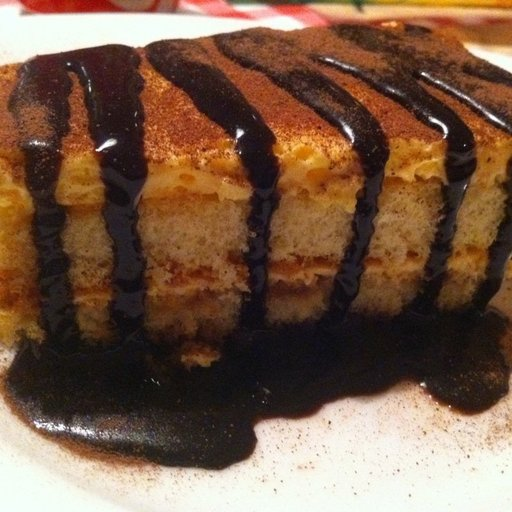

gs://johanesa-temporary-us/Food_Images/training/Dessert/1404.jpg


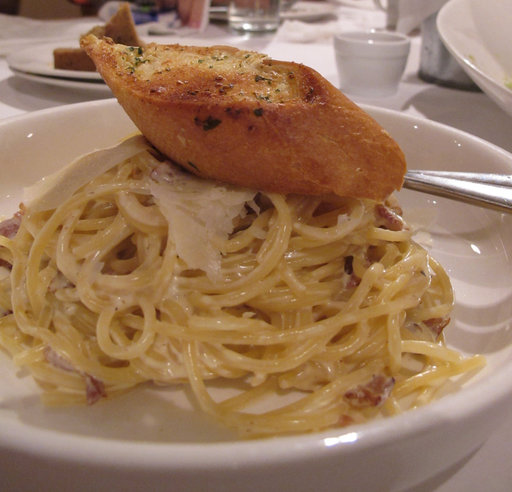

gs://johanesa-temporary-us/Food_Images/training/Noodles-Pasta/383.jpg


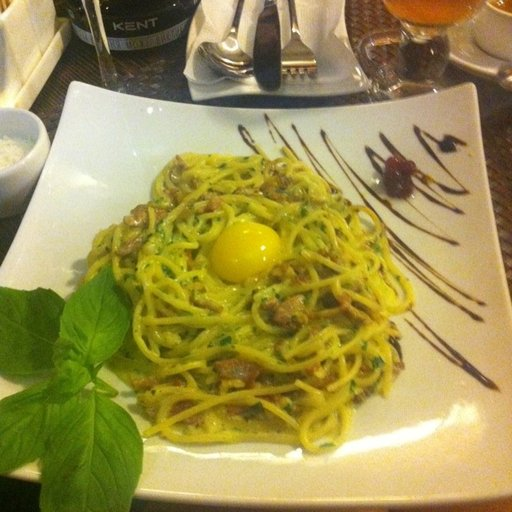

gs://johanesa-temporary-us/Food_Images/training/Noodles-Pasta/120.jpg


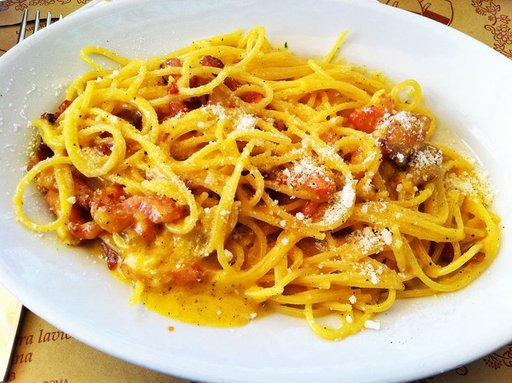

gs://johanesa-temporary-us/Food_Images/training/Noodles-Pasta/433.jpg


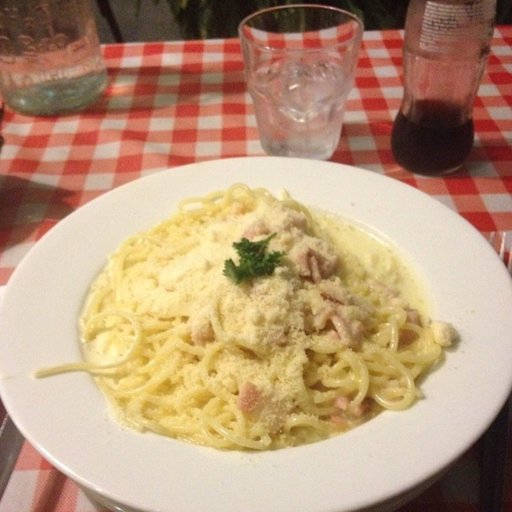

gs://johanesa-temporary-us/Food_Images/training/Noodles-Pasta/389.jpg


In [ ]:
## function call to display the semantically similar images based on the text used to search.

print("Similar images via Vector search for your input :", SEARCH_STRING)

for uri in bq_df['uri']:
    display_gcs_image(uri)
    print(uri)